TABLE VIEW TRANSFORMATION - CORRECTED
  Detected: 1 table, 37 objects
  Convex hull: 7 points
  Extracted 4 corners from convex hull
  Corner visibility:
    TL: (3.0, 447.0) - AT BORDER (cut-off)
    TR: (606.0, 358.0) - VISIBLE ✓
    BR: (799.0, 599.0) - AT BORDER (cut-off)
    BL: (3.0, 599.0) - AT BORDER (cut-off)
  Top edge: Using RANSAC
  Right edge: Using RANSAC
  Bottom edge: Using RANSAC
  Left edge: Using RANSAC
  TL: EXTRAPOLATED to (-5818.3, 523.0) [OUTSIDE FRAME]
  TR: REFINED (Extrapolated) to (651.6, 389.5)
  BR: EXTRAPOLATED to (864.3, 599.0) [OUTSIDE FRAME]
  BL: Intersection FAILED. Falling back to original corner.
  Extended canvas: 6883x800 px
  Original offset: (5919, 100)

✓ Pipeline complete!

✓ Visualization saved to: C:\Users\Owner\Desktop\MIE1517\project\YOLO_dataset\rectangular_tables\results/visualization.png


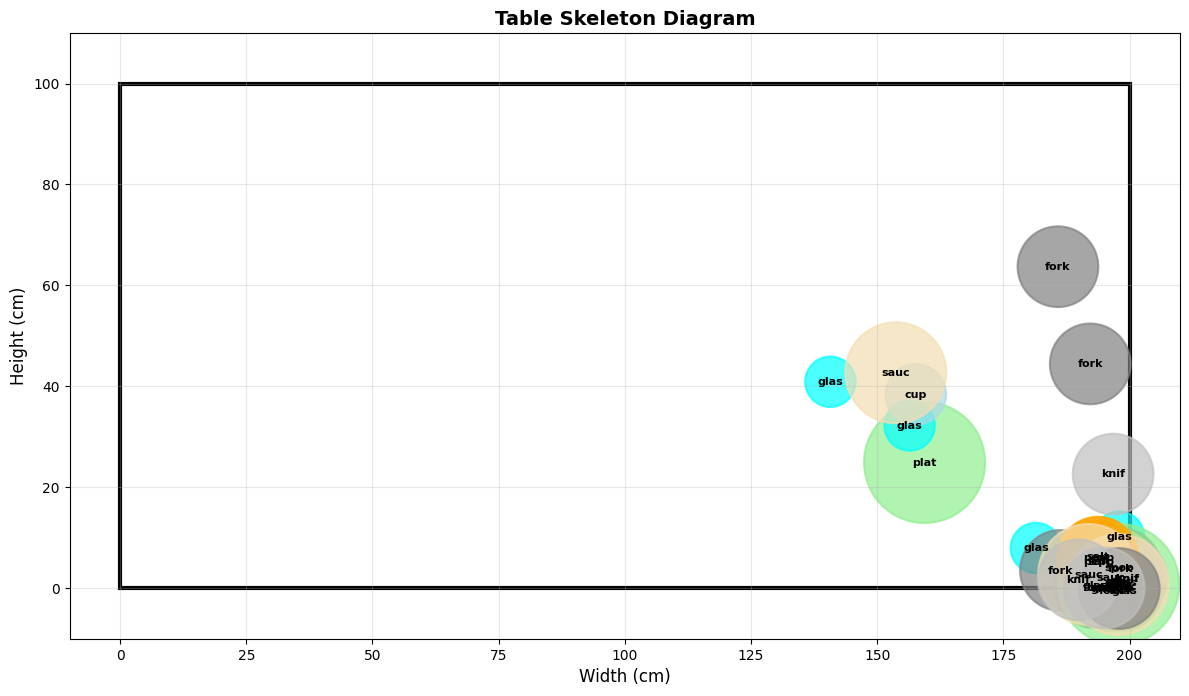

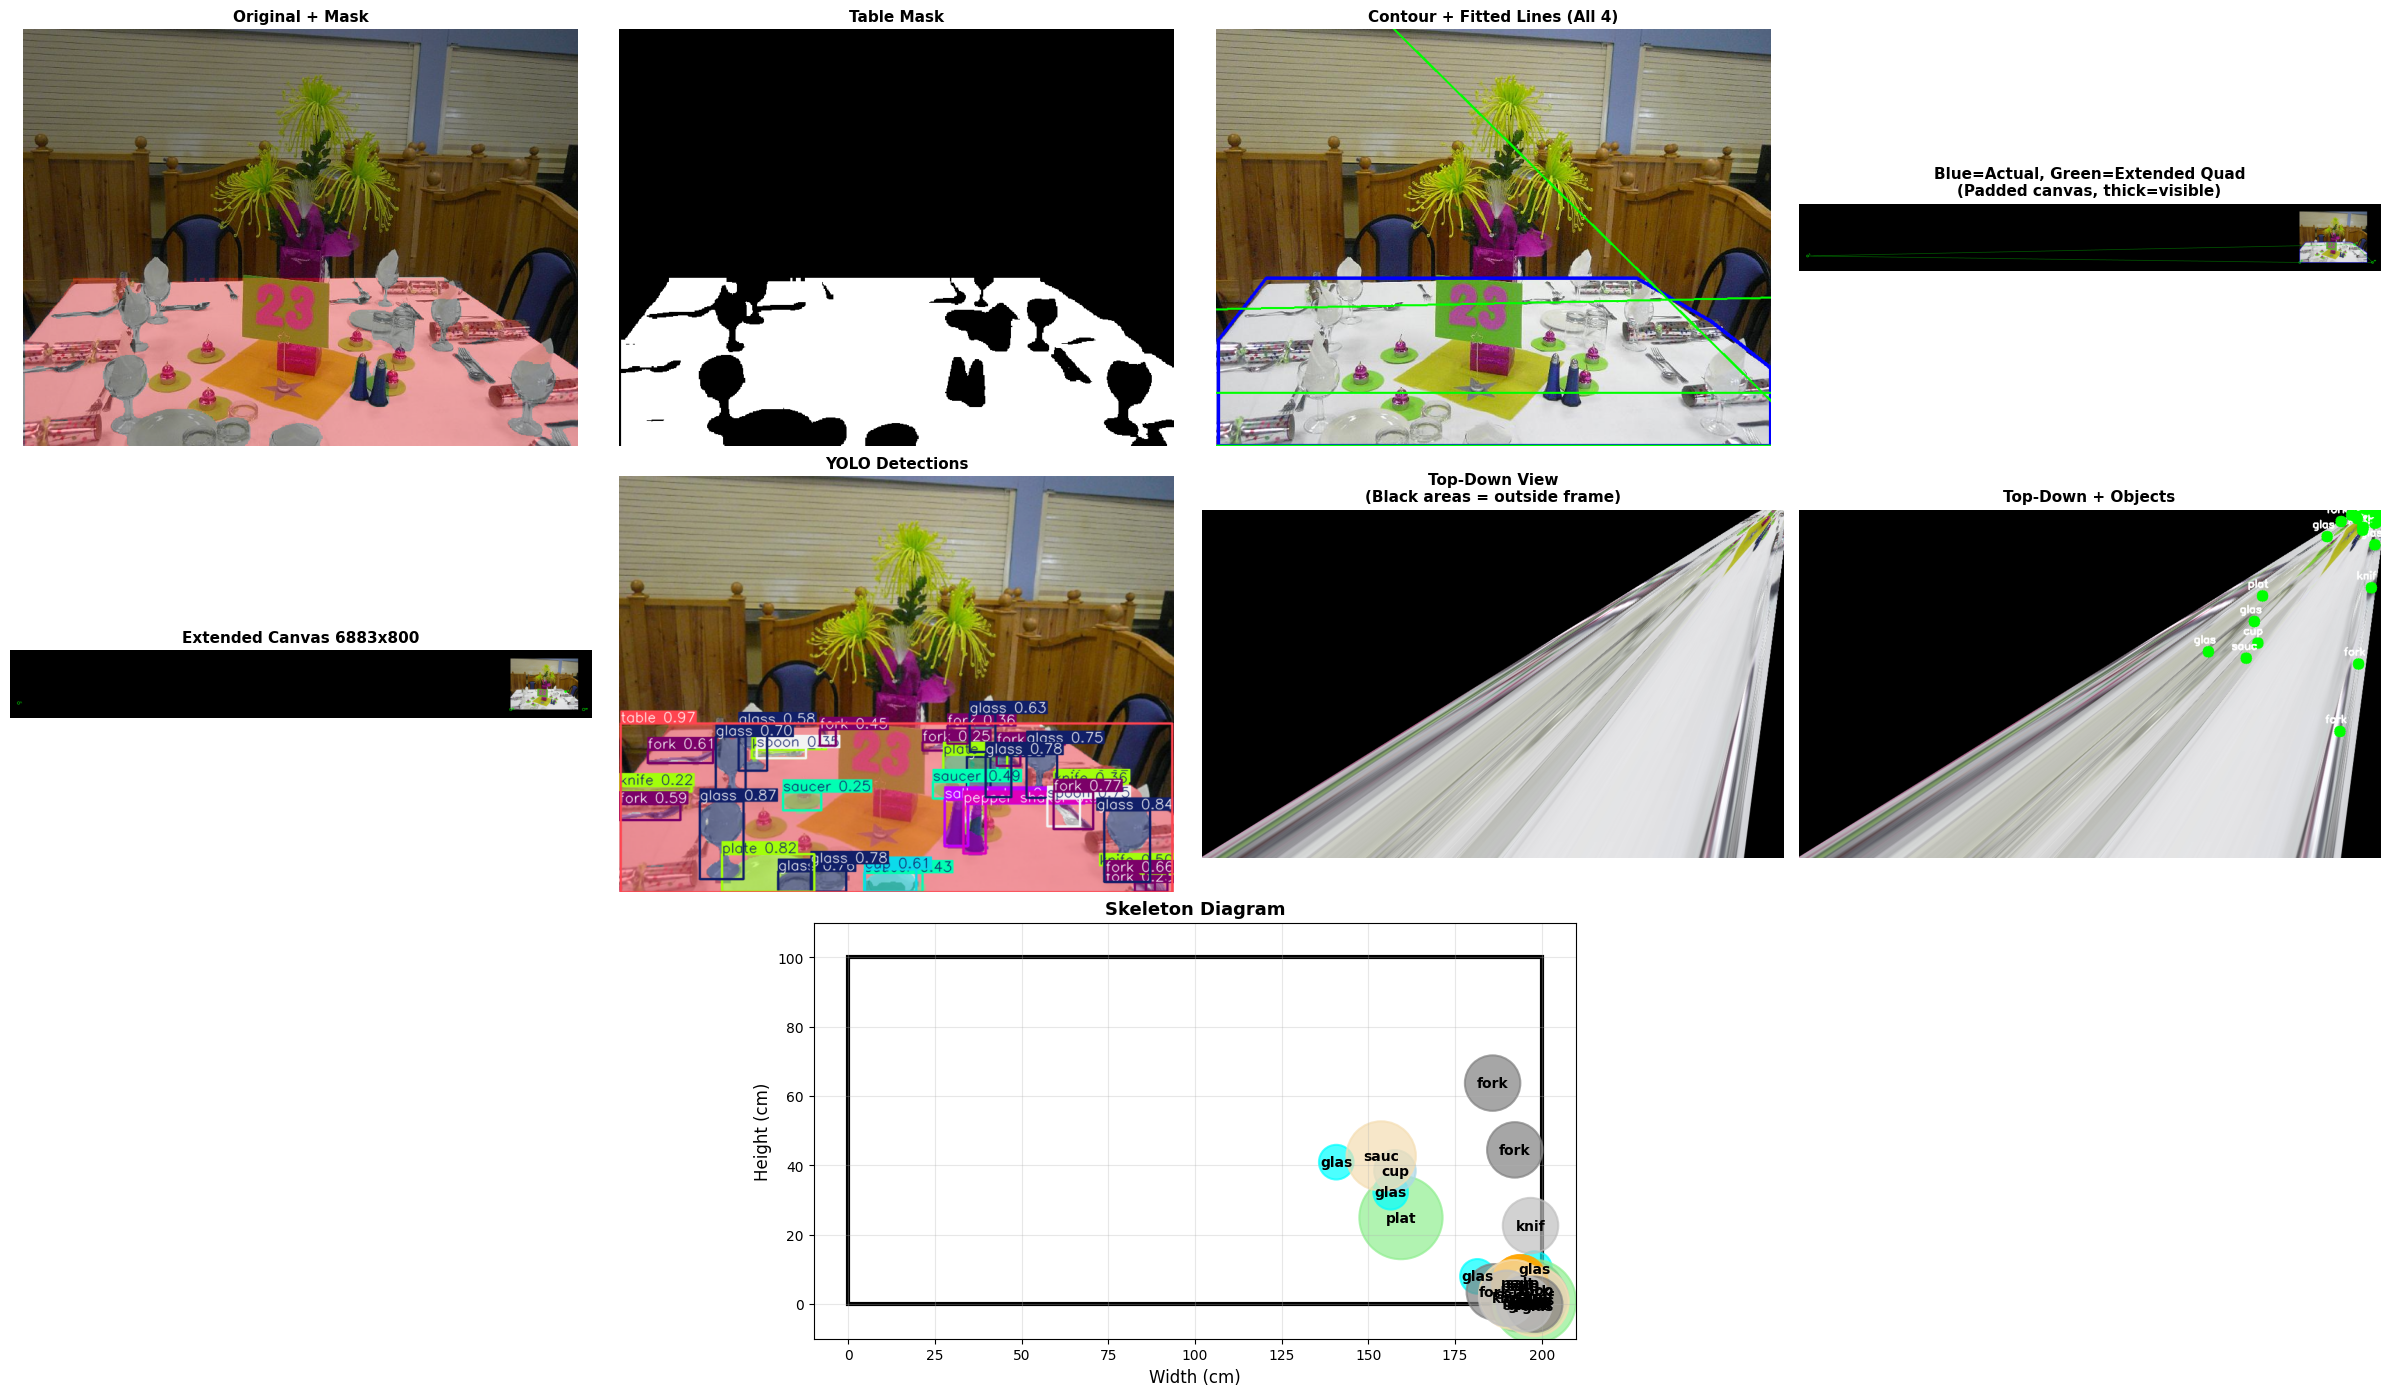


✓ All outputs saved to: C:\Users\Owner\Desktop\MIE1517\project\YOLO_dataset\rectangular_tables\results


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from scipy.spatial import ConvexHull
from sklearn.linear_model import RANSACRegressor, LinearRegression
import warnings
import os
# from scipy.interpolate import splprep, splev # NO LONGER NEEDED
warnings.filterwarnings('ignore')

class TableViewTransformerExtended:
    """Complete pipeline with proper extrapolation visualization"""
    
    def __init__(self, model_path, verbose=True):
        self.model = YOLO(model_path)
        self.verbose = verbose
        self.image = None
        self.results = None
        self.table_mask_binary = None
        self.table_contour = None
        self.objects = []
        self.table_corners = None
        self.table_corners_extended = None
        self.corner_visibility = None
        self.edge_lines = None
        self.extended_canvas = None
        self.canvas_offset = None
        self.homography_matrix = None
        self.top_down_image = None
        self.skeleton_data = None
        
    def process(self, image_path, conf_threshold=0.20):
        """Complete processing pipeline"""
        if self.verbose:
            print("="*70)
            print("TABLE VIEW TRANSFORMATION - CORRECTED")
            print("="*70)
        
        self.detect(image_path, conf_threshold)
        self.extract_table_contour() # UPDATED
        self.classify_corners()
        self.fit_edge_lines_smart()
        self.extrapolate_corners_smart() # CRITICALLY UPDATED
        self.create_extended_canvas()
        self.apply_transformation()
        self.normalize_coordinates()
        self.generate_skeleton()
        
        if self.verbose:
            print("\n✓ Pipeline complete!")
        
        return {
            'original_image': self.image,
            'extended_canvas': self.extended_canvas,
            'table_mask': self.table_mask_binary,
            'table_corners_original': self.table_corners,
            'table_corners_extended': self.table_corners_extended,
            'corner_visibility': self.corner_visibility,
            'top_down_image': self.top_down_image,
            'skeleton_diagram': self.skeleton_data,
            'objects': self.objects
        }
    
    # --- DELETED _contour_spline_smoothing_and_gap_filling METHOD ---
    # The B-Spline method has been removed as it was parameter-dependent and slow.

    
    def detect(self, image_path, conf_threshold=0.20):
        """Step 1: YOLO Detection"""
        self.image = cv2.imread(image_path)
        self.results = self.model.predict(image_path, conf=conf_threshold, verbose=False)[0]
        
        img_h, img_w = self.image.shape[:2]
        self.img_height = img_h
        self.img_width = img_w
        
        self.table_mask_binary = None
        self.objects = []
        
        for i, box in enumerate(self.results.boxes):
            class_id = int(box.cls)
            class_name = self.model.names[class_id]
            confidence = float(box.conf)
            bbox = box.xyxy[0].cpu().numpy()
            centroid = [(bbox[0] + bbox[2])/2, (bbox[1] + bbox[3])/2]
            
            mask = None
            if self.results.masks is not None and i < len(self.results.masks):
                mask_data = self.results.masks[i].data[0].cpu().numpy()
                
                if class_name == 'table':
                    self.table_mask_binary = (mask_data * 255).astype(np.uint8)
                    self.table_mask_binary = cv2.resize(
                        self.table_mask_binary, 
                        (img_w, img_h), 
                        interpolation=cv2.INTER_NEAREST
                    )
                else:
                    mask = self.results.masks[i].xy[0]
            
            if class_name != 'table':
                self.objects.append({
                    'class': class_name,
                    'confidence': confidence,
                    'bbox': bbox,
                    'centroid': centroid,
                    'mask': mask
                })
        
        if self.verbose:
            print(f"  Detected: 1 table, {len(self.objects)} objects")
        
        if self.table_mask_binary is None:
            raise ValueError("No table detected in image!")
    
    
    def extract_table_contour(self):
        """
        Extract clean table boundary using convex hull
        Then find 4 dominant corners using polygon approximation
        """
        
        # Find all table pixels
        y_coords, x_coords = np.where(self.table_mask_binary > 0)
        
        if len(x_coords) == 0:
            raise ValueError("No table pixels found in mask!")
        
        # Stack as (x, y) points
        points = np.column_stack([x_coords, y_coords]).astype(np.float32)
        
        # Compute convex hull - clean outer boundary
        hull = cv2.convexHull(points)
        
        # Use hull as our contour
        self.table_contour = hull.astype(np.int32)
        
        if self.verbose:
            print(f"  Convex hull: {len(self.table_contour)} points")
        
        # Extract 4 corners using polygon approximation
        # This is more reliable than geometric extremes for convex hulls
        epsilon = 0.02 * cv2.arcLength(self.table_contour, True)
        approx = cv2.approxPolyDP(self.table_contour, epsilon, True)
        
        # Iteratively adjust epsilon until we get 4 corners
        max_iterations = 20
        for iteration in range(max_iterations):
            if len(approx) == 4:
                # Perfect! Got exactly 4 corners
                self.table_corners = approx.reshape(4, 2).astype(np.float32)
                break
            elif len(approx) > 4:
                # Too many corners, increase epsilon (more aggressive simplification)
                epsilon *= 1.2
                approx = cv2.approxPolyDP(self.table_contour, epsilon, True)
            else:  # len(approx) < 4
                # Too few corners, decrease epsilon (less aggressive)
                epsilon *= 0.8
                approx = cv2.approxPolyDP(self.table_contour, epsilon, True)
        
        # If we still don't have exactly 4, use best approximation
        if len(approx) != 4:
            if len(approx) > 4:
                # Select 4 best corners based on angle
                self.table_corners = self._select_four_corners_from_polygon(approx.reshape(-1, 2))
            else:
                # Fallback to geometric extremes
                contour_points = self.table_contour.reshape(-1, 2)
                self.table_corners = self._get_four_corners(contour_points)
        
        # Order corners properly
        self.table_corners = self._order_corners(self.table_corners)
        
        if self.verbose:
            print(f"  Extracted 4 corners from convex hull")
    
    def _extract_corners_robust(self, contour):
        """Extract 4 corners robustly"""
        contour_points = contour.reshape(-1, 2)
        
        # Try polygon approximation
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if len(approx) == 4:
            if self.verbose:
                print("  Corner extraction: Polygon approximation (4 vertices)")
            return approx.reshape(4, 2).astype(np.float32)
        
        elif len(approx) > 4:
            if self.verbose:
                print(f"  Corner extraction: Polygon gave {len(approx)} vertices, selecting 4 best")
            corners = self._select_four_corners_from_polygon(approx.reshape(-1, 2))
            return corners
        
        # Fallback to directional extremes
        if self.verbose:
            print("  Corner extraction: Using directional extremes")
        
        img_h, img_w = self.img_height, self.img_width
        
        # Top-left
        top_candidates = contour_points[contour_points[:, 1] < img_h * 0.3]
        if len(top_candidates) > 0:
            left_candidates = top_candidates[top_candidates[:, 0] < img_w * 0.3]
            if len(left_candidates) > 0:
                top_left = left_candidates[np.argmin(left_candidates[:, 0] + left_candidates[:, 1])]
            else:
                top_left = top_candidates[np.argmin(top_candidates[:, 0])]
        else:
            top_left = contour_points[np.argmin(contour_points[:, 0] + contour_points[:, 1])]
        
        # Top-right
        if len(top_candidates) > 0:
            right_candidates = top_candidates[top_candidates[:, 0] > img_w * 0.7]
            if len(right_candidates) > 0:
                top_right = right_candidates[np.argmax(right_candidates[:, 0] - right_candidates[:, 1])]
            else:
                top_right = top_candidates[np.argmax(top_candidates[:, 0])]
        else:
            top_right = contour_points[np.argmax(contour_points[:, 0] - contour_points[:, 1])]\
        
        # Bottom-right
        bottom_candidates = contour_points[contour_points[:, 1] > img_h * 0.7]
        if len(bottom_candidates) > 0:
            right_candidates = bottom_candidates[bottom_candidates[:, 0] > img_w * 0.7]
            if len(right_candidates) > 0:
                bottom_right = right_candidates[np.argmax(right_candidates[:, 0] + right_candidates[:, 1])]
            else:
                bottom_right = bottom_candidates[np.argmax(bottom_candidates[:, 0])]
        else:
            bottom_right = contour_points[np.argmax(contour_points[:, 0] + contour_points[:, 1])]\
        
        # Bottom-left
        if len(bottom_candidates) > 0:
            left_candidates = bottom_candidates[bottom_candidates[:, 0] < img_w * 0.3]
            if len(left_candidates) > 0:
                bottom_left = left_candidates[np.argmin(left_candidates[:, 0] - left_candidates[:, 1])]
            else:
                bottom_left = bottom_candidates[np.argmin(bottom_candidates[:, 0])]
        else:
            bottom_left = contour_points[np.argmin(contour_points[:, 0] - contour_points[:, 1])]\
        
        corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)
        
        return corners
    
    def _select_four_corners_from_polygon(self, polygon_points):
        """Select 4 best corners from polygon with >4 points"""
        n = len(polygon_points)
        
        if n == 4:
            return polygon_points
        
        # Calculate angle at each vertex
        angles = []
        for i in range(n):
            p1 = polygon_points[(i - 1) % n]
            p2 = polygon_points[i]
            p3 = polygon_points[(i + 1) % n]
            
            v1 = p1 - p2
            v2 = p3 - p2
            
            cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
            angle = np.arccos(np.clip(cos_angle, -1, 1))
            angles.append(angle)
        
        # Get 4 sharpest corners
        corner_indices = np.argsort(angles)[:4]
        corner_indices = np.sort(corner_indices)
        
        return polygon_points[corner_indices].astype(np.float32)
    
    def classify_corners(self):
        """Step 3: Classify corners based on border proximity"""
        margin = 30
        
        self.corner_visibility = []
        
        for i, corner in enumerate(self.table_corners):
            x, y = corner
            
            at_left_border = x < margin
            at_right_border = x > self.img_width - margin
            at_top_border = y < margin
            at_bottom_border = y > self.img_height - margin
            
            is_visible = not (at_left_border or at_right_border or at_top_border or at_bottom_border)
            
            self.corner_visibility.append(is_visible)
        
        if self.verbose:
            labels = ['TL', 'TR', 'BR', 'BL']
            print(f"  Corner visibility:")
            for i, label in enumerate(labels):
                status = "VISIBLE ✓" if self.corner_visibility[i] else "AT BORDER (cut-off)"
                x, y = self.table_corners[i]
                print(f"    {label}: ({x:.1f}, {y:.1f}) - {status}")
    
    def fit_edge_lines_smart(self):
        """Step 4: Fit ALL 4 edge lines - guarantee we get all 4"""
        self.edge_lines = {}
        
        edges = ['top', 'right', 'bottom', 'left']
        corner_pairs = [(0, 1), (1, 2), (2, 3), (3, 0)]
        
        for edge_name, (c1_idx, c2_idx) in zip(edges, corner_pairs):
            c1_visible = self.corner_visibility[c1_idx]
            c2_visible = self.corner_visibility[c2_idx]
            
            # This is intentionally kept as the original logic to use RANSAC/fallbacks
            # The *extrapolation* is handled in the next step (extrapolate_corners_smart)
            
            # Fit line using RANSAC
            line = self._fit_edge_line_ransac(edge_name)
            
            if line is not None:
                self.edge_lines[edge_name] = line
                if self.verbose:
                    print(f"  {edge_name.capitalize()} edge: Using RANSAC")
            else:
                # Fallback: Use corner-based estimation (original logic)
                if c1_visible:
                    # Use c1 and estimate direction
                    if edge_name in ['top', 'bottom']:
                        # Horizontal-ish line through c1
                        self.edge_lines[edge_name] = (0, 1, -self.table_corners[c1_idx][1])
                    else:
                        # Vertical-ish line through c1
                        self.edge_lines[edge_name] = (1, 0, -self.table_corners[c1_idx][0])
                elif c2_visible:
                    # Use c2 and estimate direction
                    if edge_name in ['top', 'bottom']:
                        self.edge_lines[edge_name] = (0, 1, -self.table_corners[c2_idx][1])
                    else:
                        self.edge_lines[edge_name] = (1, 0, -self.table_corners[c2_idx][0])
                else:
                    # Last resort: Use image borders
                    if edge_name == 'top':
                        self.edge_lines[edge_name] = (0, 1, 0)  # y = 0
                    elif edge_name == 'bottom':
                        self.edge_lines[edge_name] = (0, 1, -self.img_height)  # y = height
                    elif edge_name == 'left':
                        self.edge_lines[edge_name] = (1, 0, 0)  # x = 0
                    elif edge_name == 'right':
                        self.edge_lines[edge_name] = (1, 0, -self.img_width)  # x = width
                
                if self.verbose:
                    print(f"  {edge_name.capitalize()} edge: Using fallback method")
        
        # CRITICAL: Verify we have all 4 lines
        if len(self.edge_lines) != 4:
            missing = set(edges) - set(self.edge_lines.keys())
            if self.verbose:
                print(f"  WARNING: Missing edge lines: {missing}")
    
    def _line_from_two_points(self, p1, p2):
        """Create exact line equation from two points"""
        x1, y1 = p1
        x2, y2 = p2
        
        a = y2 - y1
        b = -(x2 - x1)
        c = (x2 - x1) * y1 - (y2 - y1) * x1
        
        norm = np.sqrt(a**2 + b**2)
        if norm > 1e-6:
            return (a/norm, b/norm, c/norm)
        else:
            return (a, b, c)
    
    def _fit_edge_line_ransac(self, edge_name):
        """
        Fit line using points from the CONVEX HULL near each edge
        Uses the actual corner positions to determine which hull points belong to each edge
        """
        
        # Get hull points
        hull_points = self.table_contour.reshape(-1, 2)
        
        # Get the two corners that define this edge
        edge_corner_indices = {
            'top': (0, 1),      # TL to TR
            'right': (1, 2),    # TR to BR
            'bottom': (2, 3),   # BR to BL
            'left': (3, 0)      # BL to TL
        }
        
        if edge_name not in edge_corner_indices:
            return None
        
        c1_idx, c2_idx = edge_corner_indices[edge_name]
        corner1 = self.table_corners[c1_idx]
        corner2 = self.table_corners[c2_idx]
        
        # Find hull points that are close to the line between these corners
        # Line from corner1 to corner2
        line_vec = corner2 - corner1
        line_length = np.linalg.norm(line_vec)
        
        if line_length < 1:
            return None
        
        line_vec_norm = line_vec / line_length
        
        # For each hull point, compute distance to the line segment
        edge_points = []
        threshold = max(self.img_width, self.img_height) * 0.1  # 10% of image size
        
        for point in hull_points:
            # Vector from corner1 to point
            to_point = point - corner1
            
            # Project onto line direction
            projection = np.dot(to_point, line_vec_norm)
            
            # Check if projection is between corner1 and corner2
            if -line_length * 0.2 < projection < line_length * 1.2:
                # Compute perpendicular distance
                closest_point = corner1 + projection * line_vec_norm
                distance = np.linalg.norm(point - closest_point)
                
                if distance < threshold:
                    edge_points.append(point)
        
        # If we have enough points, fit a line
        if len(edge_points) >= 2:
            edge_points = np.array(edge_points)
            
            try:
                X = edge_points[:, 0].reshape(-1, 1)
                y = edge_points[:, 1]
                
                if len(edge_points) >= 5:
                    # Use RANSAC
                    ransac = RANSACRegressor(
                        random_state=42,
                        min_samples=min(5, len(edge_points)//2),
                        residual_threshold=5.0
                    )
                    ransac.fit(X, y)
                    m = ransac.estimator_.coef_[0]
                    b = ransac.estimator_.intercept_
                else:
                    # Use simple linear regression
                    from sklearn.linear_model import LinearRegression
                    lr = LinearRegression()
                    lr.fit(X, y)
                    m = lr.coef_[0]
                    b = lr.intercept_
                
                # Convert to line equation: ax + by + c = 0
                a = m
                b_coef = -1
                c = b
                
                norm = np.sqrt(a**2 + b_coef**2)
                return (a/norm, b_coef/norm, c/norm)
            except:
                pass
        
        # Fallback: use the two corners to define the line
        return self._line_from_two_points(corner1, corner2)

    
    def extrapolate_corners_smart(self):
        """
        Step 5: ALWAYS calculate extended corners from the intersection of the 
        RANSAC fitted edge lines to overcome the recessed YOLO boundary problem.
        """
        if len(self.edge_lines) != 4:
            if self.verbose:
                print("  WARNING: Not all 4 edge lines are available. Skipping extrapolation.")
            self.table_corners_extended = self.table_corners.copy()
            return
        
        extended_corners = []
        labels = ['TL', 'TR', 'BR', 'BL']
        edge_pairs = [
            ('top', 'left'),
            ('top', 'right'),
            ('bottom', 'right'),
            ('bottom', 'left')
        ]
        
        for i in range(4):
            edge1, edge2 = edge_pairs[i]
            
            # --- CRITICAL CHANGE: ALWAYS EXTRAPOLATE USING FITTED LINES ---
            # This forces the corner to be defined by the intersection of the two 
            # RANSAC/fallback-fitted lines, pushing the boundary outward past the recessed mask edge.
            corner = self._line_intersection(
                self.edge_lines[edge1], 
                self.edge_lines[edge2]
            )
            
            if corner is not None:
                extended_corners.append(corner)
                outside = ""
                
                # For logging only: check if the extrapolated point falls outside the original frame
                if corner[0] < 0 or corner[0] > self.img_width or corner[1] < 0 or corner[1] > self.img_height:
                    outside = " [OUTSIDE FRAME]"
                
                status = "EXTRAPOLATED"
                if self.corner_visibility[i]:
                     # This indicates a visible but recessed corner was pushed outward by the RANSAC lines
                     status = "REFINED (Extrapolated)" 
                
                if self.verbose:
                    print(f"  {labels[i]}: {status} to ({corner[0]:.1f}, {corner[1]:.1f}){outside}")
            
            else:
                # Fallback to the original recessed corner if intersection fails (should be rare)
                extended_corners.append(self.table_corners[i])
                if self.verbose:
                    print(f"  {labels[i]}: Intersection FAILED. Falling back to original corner.")
        
        self.table_corners_extended = np.array(extended_corners, dtype=np.float32)
    
    def _line_intersection(self, line1, line2):
        """Find intersection of two lines"""
        a1, b1, c1 = line1
        a2, b2, c2 = line2
        
        det = a1 * b2 - a2 * b1
        
        if abs(det) < 1e-6:
            return None
        
        x = (b1 * c2 - b2 * c1) / det
        y = (a2 * c1 - a1 * c2) / det
        
        return np.array([x, y])
    
    def create_extended_canvas(self):
        """Step 6: Create padded canvas for visualization and homography"""
        # Find bounding box of extended corners
        min_x = np.min(self.table_corners_extended[:, 0])
        max_x = np.max(self.table_corners_extended[:, 0])
        min_y = np.min(self.table_corners_extended[:, 1])
        max_y = np.max(self.table_corners_extended[:, 1])
        
        # Ensure canvas contains entire original image
        min_x = min(min_x, 0)
        max_x = max(max_x, self.img_width)
        min_y = min(min_y, 0)
        max_y = max(max_y, self.img_height)
        
        # Add padding for visibility of extensions
        padding = 100
        min_x -= padding
        max_x += padding
        min_y -= padding
        max_y += padding
        
        # Calculate canvas size
        canvas_width = int(np.ceil(max_x - min_x))
        canvas_height = int(np.ceil(max_y - min_y))
        
        # Calculate offset for placing original image
        self.canvas_offset = (-int(np.floor(min_x)), -int(np.floor(min_y)))
        
        if self.verbose:
            print(f"  Extended canvas: {canvas_width}x{canvas_height} px")
            print(f"  Original offset: {self.canvas_offset}")
        
        # Verify canvas size
        offset_x, offset_y = self.canvas_offset
        required_width = offset_x + self.img_width
        required_height = offset_y + self.img_height
        
        if canvas_width < required_width or canvas_height < required_height:
            canvas_width = max(canvas_width, required_width + 50)
            canvas_height = max(canvas_height, required_height + 50)
        
        # Create extended canvas (black background)
        self.extended_canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
        
        # Place original image in canvas
        self.extended_canvas[offset_y:offset_y+self.img_height, 
                            offset_x:offset_x+self.img_width] = self.image
        
        # Adjust corner coordinates to canvas space
        self.table_corners_canvas = self.table_corners_extended.copy()
        self.table_corners_canvas[:, 0] += self.canvas_offset[0]
        self.table_corners_canvas[:, 1] += self.canvas_offset[1]
        
        # Compute homography for top-down view
        target_width = 1000
        target_height = 600
        
        dst_corners = np.array([
            [0, 0],
            [target_width, 0],
            [target_width, target_height],
            [0, target_height]
        ], dtype=np.float32)
        
        self.homography_matrix, _ = cv2.findHomography(self.table_corners_canvas, dst_corners)
        self.target_width = target_width
        self.target_height = target_height
    
    def apply_transformation(self):
        """Step 7: Apply transformation"""
        self.top_down_image = cv2.warpPerspective(
            self.extended_canvas,
            self.homography_matrix,
            (self.target_width, self.target_height)
        )
        
        for obj in self.objects:
            centroid_img = np.array(obj['centroid'])
            centroid_canvas = centroid_img + np.array(self.canvas_offset)
            
            centroid = np.array([[centroid_canvas]], dtype=np.float32)
            transformed = cv2.perspectiveTransform(centroid, self.homography_matrix)
            obj['centroid_transformed'] = transformed[0][0]
            
            if obj['mask'] is not None:
                mask_canvas = obj['mask'] + np.array(self.canvas_offset)
                mask_points = mask_canvas.reshape(-1, 1, 2).astype(np.float32)
                transformed_mask = cv2.perspectiveTransform(mask_points, self.homography_matrix)
                obj['mask_transformed'] = transformed_mask.reshape(-1, 2)
    
    def normalize_coordinates(self, table_width_cm=200, table_height_cm=100):
        """Normalize to real-world coordinates"""
        px_to_cm_x = table_width_cm / self.target_width
        px_to_cm_y = table_height_cm / self.target_height
        
        for obj in self.objects:
            x_cm = obj['centroid_transformed'][0] * px_to_cm_x
            y_cm = obj['centroid_transformed'][1] * px_to_cm_y
            obj['position_cm'] = [x_cm, y_cm]
    
    def generate_skeleton(self):
        """Generate skeleton diagram"""
        fig, ax = plt.subplots(figsize=(12, 8))
        
        table_rect = Rectangle((0, 0), 200, 100, 
                               fill=False, edgecolor='black', linewidth=3)
        ax.add_patch(table_rect)
        
        class_colors = {
            'plate': 'lightgreen', 'cup': 'lightblue', 'glass': 'cyan',
            'fork': 'gray', 'knife': 'silver', 'spoon': 'lightgray', 
            'saucer': 'wheat', 'bowl': 'wheat'
        }
        
        class_sizes = {
            'plate': 12, 'cup': 6, 'glass': 5, 'fork': 8, 'knife': 8, 
            'spoon': 6, 'saucer': 10, 'bowl': 10
        }
        
        for obj in self.objects:
            x, y = obj['position_cm']
            class_name = obj['class']
            
            color = class_colors.get(class_name, 'orange')
            size = class_sizes.get(class_name, 8)
            
            circle = Circle((x, y), size, color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
            ax.add_patch(circle)
            ax.text(x, y, class_name[:4], ha='center', va='center', 
                   fontsize=8, fontweight='bold')
        
        ax.set_xlim(-10, 210)
        ax.set_ylim(-10, 110)
        ax.set_aspect('equal')
        ax.set_xlabel('Width (cm)', fontsize=12)
        ax.set_ylabel('Height (cm)', fontsize=12)
        ax.set_title('Table Skeleton Diagram', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        self.skeleton_data = fig
    
    def _get_four_corners(self, points):
        """Get 4 extreme corner points"""
        top_left = points[np.argmin(points[:, 0] + points[:, 1])]
        top_right = points[np.argmax(points[:, 0] - points[:, 1])]
        bottom_right = points[np.argmax(points[:, 0] + points[:, 1])]
        bottom_left = points[np.argmin(points[:, 0] - points[:, 1])]
        
        return np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)
    
    def _order_corners(self, corners):
        """Order corners properly"""
        centroid = np.mean(corners, axis=0)
        angles = np.arctan2(corners[:, 1] - centroid[1], corners[:, 0] - centroid[0])
        sorted_indices = np.argsort(angles)
        sums = corners[:, 0] + corners[:, 1]
        tl_idx = np.argmin(sums)
        ordered = np.roll(corners[sorted_indices], -np.where(sorted_indices == tl_idx)[0][0], axis=0)
        return ordered.astype(np.float32)
    
    def _build_extended_contour_simple(self):

        # Use the 4 extended corners
        corners = self.table_corners_extended
        
        # Create quadrilateral: TL → TR → BR → BL → TL
        # Add interpolation points for smoother visualization
        extended_points = []
        
        for i in range(4):
            corner1 = corners[i]
            corner2 = corners[(i + 1) % 4]
            
            # Add current corner
            extended_points.append(corner1)
            
            # Add 9 interpolated points between corners for smooth line drawing
            for t in np.linspace(0.1, 0.9, 9):
                interp_point = corner1 + t * (corner2 - corner1)
                extended_points.append(interp_point)
        
        # Convert to contour format
        extended_contour = np.array(extended_points, dtype=np.float32)
        extended_contour = extended_contour.reshape(-1, 1, 2).astype(np.int32)
        
        return extended_contour
    
    def _get_edge_contour_points(self, edge_name):
        """Get actual contour points for a specific edge"""
        original_points = self.table_contour.reshape(-1, 2)
        
        # More generous margins to capture edge points
        if edge_name == 'top':
            mask = original_points[:, 1] < self.img_height * 0.3
            edge_pts = original_points[mask]
            return edge_pts[np.argsort(edge_pts[:, 0])] if len(edge_pts) > 0 else np.array([])
            
        elif edge_name == 'right':
            mask = original_points[:, 0] > self.img_width * 0.7
            edge_pts = original_points[mask]
            return edge_pts[np.argsort(edge_pts[:, 1])] if len(edge_pts) > 0 else np.array([])
            
        elif edge_name == 'bottom':
            mask = original_points[:, 1] > self.img_height * 0.7
            edge_pts = original_points[mask]
            return edge_pts[np.argsort(-edge_pts[:, 0])] if len(edge_pts) > 0 else np.array([])
            
        elif edge_name == 'left':
            mask = original_points[:, 0] < self.img_width * 0.3
            edge_pts = original_points[mask]
            return edge_pts[np.argsort(-edge_pts[:, 1])] if len(edge_pts) > 0 else np.array([])
            
        return np.array([])

    def visualize_results(self, save_path=None):
        """Visualize with CORRECTED approach - simple quadrilateral"""
        fig = plt.figure(figsize=(24, 14))
        
        # 1. Original + Mask
        ax1 = plt.subplot(3, 4, 1)
        img_with_mask = self.image.copy()
        mask_colored = np.zeros_like(self.image)
        mask_colored[:, :, 2] = self.table_mask_binary
        img_with_mask = cv2.addWeighted(img_with_mask, 0.7, mask_colored, 0.3, 0)
        ax1.imshow(cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original + Mask', fontsize=11, fontweight='bold')
        ax1.axis('off')
        
        # 2. Table Mask
        ax2 = plt.subplot(3, 4, 2)
        ax2.imshow(self.table_mask_binary, cmap='gray')
        ax2.set_title('Table Mask', fontsize=11, fontweight='bold')
        ax2.axis('off')
        
        # 3. Contour + Fitted Lines (SHOW ALL 4 LINES!)
        ax3 = plt.subplot(3, 4, 3)
        img_lines = self.image.copy()
        cv2.drawContours(img_lines, [self.table_contour], -1, (255, 0, 0), 3)
        
        # Draw ALL 4 fitted lines (extended beyond image)
        line_extension = 200  # Extend lines beyond image boundaries
        
        for edge_name, (a, b, c) in self.edge_lines.items():
            if abs(b) > 0.1:
                # Line equation: y = (-a*x - c) / b
                x1, x2 = -line_extension, self.img_width + line_extension
                y1 = (-c - a * x1) / b
                y2 = (-c - a * x2) / b
                cv2.line(img_lines, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            else:
                # Vertical line: x = -c / a
                x = -c / a
                cv2.line(img_lines, (int(x), -line_extension), (int(x), self.img_height + line_extension), (0, 255, 0), 2)
        
        ax3.imshow(cv2.cvtColor(img_lines, cv2.COLOR_BGR2RGB))
        ax3.set_title('Contour + Fitted Lines (All 4)', fontsize=11, fontweight='bold')
        ax3.axis('off')
        
        # 4. Blue=Actual Contour, Green=Simple Quadrilateral (on padded canvas)
        ax4 = plt.subplot(3, 4, 4)
        
        # Get canvas offset
        offset_x, offset_y = self.canvas_offset
        vis_canvas = self.extended_canvas.copy()
        
        # Shift original contour to canvas coordinates
        contour_shifted = self.table_contour.copy()
        contour_shifted[:, 0, 0] += offset_x
        contour_shifted[:, 0, 1] += offset_y
        
        # Build simple quadrilateral from extended corners
        extended_contour_original = self._build_extended_contour_simple()
        
        # Shift to canvas coordinates
        extended_contour_canvas = extended_contour_original.copy()
        extended_contour_canvas[:, 0, 0] += offset_x
        extended_contour_canvas[:, 0, 1] += offset_y
        
        # Draw GREEN first (background): Simple quadrilateral
        cv2.drawContours(vis_canvas, [extended_contour_canvas], -1, (0, 255, 0), 2)
        
        # Draw BLUE on top (foreground): Original contour
        cv2.drawContours(vis_canvas, [contour_shifted], -1, (255, 0, 0), 3)
        
        # Draw corner circles and labels
        for i, corner in enumerate(self.table_corners_canvas):
            corner_int = tuple(corner.astype(int))
            
            if self.corner_visibility[i]:
                # Thick green circle for visible corners
                cv2.circle(vis_canvas, corner_int, 12, (0, 255, 0), 5)
            else:
                # Thin green circle for extrapolated corners
                cv2.circle(vis_canvas, corner_int, 12, (0, 255, 0), 3)
            
            # Add labels
            labels = ['TL', 'TR', 'BR', 'BL']
            label_offset = np.array([15, -15])
            label_pos = tuple((corner + label_offset).astype(int))
            cv2.putText(vis_canvas, labels[i], label_pos,
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        ax4.imshow(cv2.cvtColor(vis_canvas, cv2.COLOR_BGR2RGB))
        ax4.set_title('Blue=Actual, Green=Extended Quad\n(Padded canvas, thick=visible)', 
                    fontsize=11, fontweight='bold')
        ax4.axis('off')
        
        # 5. Extended Canvas
        ax5 = plt.subplot(3, 4, 5)
        canvas_vis = self.extended_canvas.copy()
        
        # Draw all 4 corners with labels
        for i, corner in enumerate(self.table_corners_canvas):
            thickness = -1 if self.corner_visibility[i] else 3
            cv2.circle(canvas_vis, tuple(corner.astype(int)), 15, (0, 255, 0), thickness)
            
            labels = ['TL', 'TR', 'BR', 'BL']
            cv2.putText(canvas_vis, labels[i], tuple((corner + np.array([20, 0])).astype(int)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        ax5.imshow(cv2.cvtColor(canvas_vis, cv2.COLOR_BGR2RGB))
        ax5.set_title(f'Extended Canvas {canvas_vis.shape[1]}x{canvas_vis.shape[0]}', 
                    fontsize=11, fontweight='bold')
        ax5.axis('off')
        
        # 6. YOLO Detections
        ax6 = plt.subplot(3, 4, 6)
        detection_img = self.results.plot()
        ax6.imshow(detection_img[..., ::-1])
        ax6.set_title('YOLO Detections', fontsize=11, fontweight='bold')
        ax6.axis('off')
        
        # 7. Top-down View
        ax7 = plt.subplot(3, 4, 7)
        ax7.imshow(cv2.cvtColor(self.top_down_image, cv2.COLOR_BGR2RGB))
        ax7.set_title('Top-Down View\n(Black areas = outside frame)', fontsize=11, fontweight='bold')
        ax7.axis('off')
        
        # 8. Top-down + Objects
        ax8 = plt.subplot(3, 4, 8)
        top_down_annotated = self.top_down_image.copy()
        for obj in self.objects:
            x, y = obj['centroid_transformed'].astype(int)
            cv2.circle(top_down_annotated, (x, y), 10, (0, 255, 0), -1)
            cv2.putText(top_down_annotated, obj['class'][:4], (x-25, y-15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        ax8.imshow(cv2.cvtColor(top_down_annotated, cv2.COLOR_BGR2RGB))
        ax8.set_title('Top-Down + Objects', fontsize=11, fontweight='bold')
        ax8.axis('off')
        
        # 9-12. Skeleton Diagram
        ax9 = plt.subplot(3, 4, (9, 12))
        table_rect = Rectangle((0, 0), 200, 100, 
                            fill=False, edgecolor='black', linewidth=3)
        ax9.add_patch(table_rect)
        
        class_colors = {
            'plate': 'lightgreen', 'cup': 'lightblue', 'glass': 'cyan',
            'fork': 'gray', 'knife': 'silver', 'spoon': 'lightgray', 
            'saucer': 'wheat', 'bowl': 'wheat'
        }
        class_sizes = {
            'plate': 12, 'cup': 6, 'glass': 5, 'fork': 8, 'knife': 8, 
            'spoon': 6, 'saucer': 10, 'bowl': 10
        }
        
        for obj in self.objects:
            x, y = obj['position_cm']
            color = class_colors.get(obj['class'], 'orange')
            size = class_sizes.get(obj['class'], 8)
            circle = Circle((x, y), size, color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
            ax9.add_patch(circle)
            ax9.text(x, y, obj['class'][:4], ha='center', va='center', 
                    fontsize=10, fontweight='bold')
        
        ax9.set_xlim(-10, 210)
        ax9.set_ylim(-10, 110)
        ax9.set_aspect('equal')
        ax9.set_xlabel('Width (cm)', fontsize=12)
        ax9.set_ylabel('Height (cm)', fontsize=12)
        ax9.set_title('Skeleton Diagram', fontsize=13, fontweight='bold')
        ax9.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            if self.verbose:
                print(f"\n✓ Visualization saved to: {save_path}")
        
        plt.show()
    
    def export_data(self):
        """Export all data"""
        return {
            'table_corners_original': self.table_corners.astype(float).tolist(),
            'table_corners_extended': self.table_corners_extended.astype(float).tolist(),
            'corner_visibility': [bool(x) for x in self.corner_visibility],\
            'canvas_size': [int(self.extended_canvas.shape[1]), int(self.extended_canvas.shape[0])],\
            'canvas_offset': [int(self.canvas_offset[0]), int(self.canvas_offset[1])],\
            'homography_matrix': self.homography_matrix.astype(float).tolist(),\
            'edge_lines_detected': list(self.edge_lines.keys()),\
            'objects': [\
                {\
                    'class': obj['class'],\
                    'confidence': float(obj['confidence']),\
                    'original_position': [float(x) for x in obj['centroid']],\
                    'top_down_position_px': [float(x) for x in obj['centroid_transformed']],\
                    'real_world_position_cm': [float(x) for x in obj['position_cm']]\
                }\
                for obj in self.objects\
            ]\
        }


# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    import json
    
    model_path = r'C:\Users\Owner\Desktop\MIE1517\project\runs\segment\tableware_yolov11m\weights\best.pt'
    test_image_path = r'C:\Users\Owner\Desktop\MIE1517\project\YOLO_dataset\rectangular_tables\images\test_5487.jpg'
    output_folder = r'C:\Users\Owner\Desktop\MIE1517\project\YOLO_dataset\rectangular_tables\results'
    
    os.makedirs(output_folder, exist_ok=True)
    
    transformer = TableViewTransformerExtended(model_path, verbose=True)
    results = transformer.process(test_image_path, conf_threshold=0.20)
    
    transformer.visualize_results(save_path=f'{output_folder}/visualization.png')
    
    # Save outputs
    cv2.imwrite(f'{output_folder}/top_down.jpg', results['top_down_image'])
    cv2.imwrite(f'{output_folder}/extended_canvas.jpg', results['extended_canvas'])
    
    results['skeleton_diagram'].savefig(f'{output_folder}/skeleton.png', dpi=150, bbox_inches='tight')
    
    data = transformer.export_data()
    with open(f'{output_folder}/data.json', 'w') as f:
        json.dump(data, f, indent=2)
    
    print(f"\n✓ All outputs saved to: {output_folder}")